# Data Loader

[reference](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [1]:
from tqdm.notebook import tqdm
import segmentation_models_pytorch as smp
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
None

In [2]:
annotations = pd.read_csv("../data/bitmoji_annotation.csv")
annotations

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,user278_1577.jpg,142777,{},1,0,"{""name"":""polygon"",""all_points_x"":[284,268,291,...","{""face"":undefined}"
1,user278_1578.jpg,58396,{},1,0,"{""name"":""polygon"",""all_points_x"":[371,355,370,...","{""face"":undefined}"
2,user278_1579.jpg,101992,{},1,0,"{""name"":""polygon"",""all_points_x"":[559,550,588,...","{""face"":undefined}"
3,user279_223.jpg,102630,{},1,0,"{""name"":""polygon"",""all_points_x"":[556,549,561,...","{""face"":undefined}"
4,user280_1580.jpg,76383,{},1,0,"{""name"":""polygon"",""all_points_x"":[33,25,81,148...","{""face"":undefined}"
...,...,...,...,...,...,...,...
234,user539_4289.jpg,138507,{},1,0,"{""name"":""polygon"",""all_points_x"":[342,337,326,...","{""face"":undefined}"
235,user540_4290.jpg,108583,{},1,0,"{""name"":""polygon"",""all_points_x"":[135,148,151,...","{""face"":undefined}"
236,user540_4802.jpg,79183,{},1,0,"{""name"":""polygon"",""all_points_x"":[309,315,311,...","{""face"":undefined}"
237,user541_3651.jpg,83728,{},2,0,"{""name"":""polygon"",""all_points_x"":[70,105,124,1...","{""face"":undefined}"


In [3]:
import json
n = 3
img_name = annotations.iloc[n, 0]
landmarks = json.loads(annotations.iloc[n, 5])
landmarks = np.array(list(zip(landmarks['all_points_x'],landmarks['all_points_y'])))

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: user279_223.jpg
Landmarks shape: (7, 2)
First 4 Landmarks: [[556 248]
 [549 295]
 [561 317]
 [596 311]]


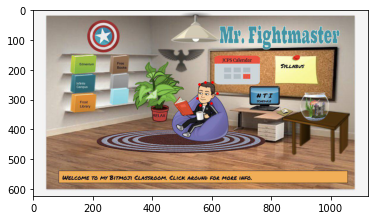

In [4]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    try:
        plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
        plt.pause(0.001)  # pause a bit so that plots are updated
    except:
        pass

plt.figure()
show_landmarks(io.imread(os.path.join('../data/training/', img_name)),
               landmarks)
plt.show()

In [5]:
from utils import FaceLandmarksDataset

0 (540, 960, 3) (15, 2)


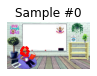

1 (673, 1200, 3) (15, 2)


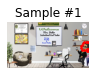

2 (540, 960, 3) (0, 2)


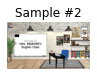

3 (667, 1200, 3) (14, 2)


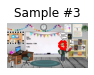

In [6]:
face_dataset = FaceLandmarksDataset(csv_file='../data/bitmoji_annotation.csv',
                                    root_dir='../data/training/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i+123]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(i + 1, 4, 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

In [7]:
# Get average image dimension
from glob import glob
import cv2
paths = glob('../data/training/*')
imgs = [cv2.imread(path,0) for path in paths]
dims = np.array([im.shape[:2] for im in imgs])
dim = tuple((dims.mean(axis=0)/2).astype(int))
dim

(320, 532)

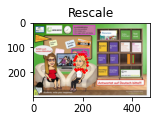

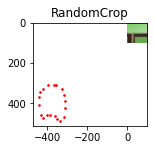

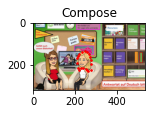

In [8]:
from utils import Rescale,RandomCrop,ToTensor

scale = Rescale(300)
crop = RandomCrop(100)
composed = transforms.Compose([Rescale((400,600)),
                               RandomCrop(dim)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()


0 torch.Size([1, 3, 320, 532]) torch.Size([1, 21, 2])
1 torch.Size([1, 3, 320, 532]) torch.Size([1, 13, 2])
2 torch.Size([1, 3, 320, 532]) torch.Size([1, 9, 2])
3 torch.Size([1, 3, 320, 532]) torch.Size([1, 16, 2])


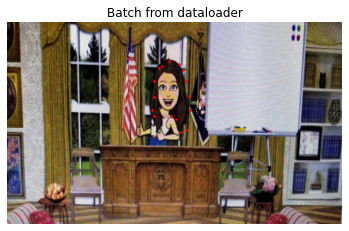

In [9]:
transformed_dataset = FaceLandmarksDataset(csv_file='../data/bitmoji_annotation.csv',
                                           root_dir='../data/training/',
                                           transform=transforms.Compose([Rescale((400,600)),
                                                                         RandomCrop(dim),
                                                                         ToTensor()]))


dataloader = DataLoader(transformed_dataset, batch_size=1,
                        shuffle=True)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break